In [1]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from keras import backend as K
from keras import layers
from keras.utils.np_utils import to_categorical   
from keras import models, optimizers
from keras import metrics
from keras.datasets import cifar10

/Users/nadya-bu/au/7term/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
original_img_size = (32, 32, 3)

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [147]:
def get_only_classes(classes, x, y):
    index = y == classes[0]
    for clazz in classes[1:]:
        index = np.logical_or(index, y == clazz)
        
    index = index.squeeze()
        
    new_x = x[index]
    new_y = to_categorical(y[index], len(classes))
    
    p = np.random.permutation(new_x.shape[0])
    return new_x[p], new_y[p]

In [148]:
x_train10, y_train10 = get_only_classes(list(range(10)), x_train, y_train)
x_test10, y_test10 = get_only_classes(list(range(10)), x_test, y_test)
x_train10.shape, y_train10.shape, x_test10.shape, y_test10.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [149]:
x_train2, y_train2 = get_only_classes(list(range(2)), x_train, y_train)
x_test2, y_test2 = get_only_classes(list(range(2)), x_test, y_test)
x_train2.shape, y_train2.shape, x_test2.shape, y_test2.shape

((10000, 32, 32, 3), (10000, 2), (2000, 32, 32, 3), (2000, 2))

In [150]:
x_train1, y_train1 = get_only_classes(list(range(1)), x_train, y_train)
x_test1, y_test1 = get_only_classes(list(range(1)), x_test, y_test)
x_train1.shape, y_train1.shape, x_test1.shape, y_test1.shape

((5000, 32, 32, 3), (5000, 1), (1000, 32, 32, 3), (1000, 1))

In [152]:
nbatch = 100
latent_size = 30

In [175]:
class base_CVAE():
    def  __init__(self, batch_size, latent_size, original_dim, ans_size, step=None):
        self.batch_size = batch_size
        self.latent_size = latent_size
        self.original_dim = original_dim
        self.ans_size = ans_size
        
        pic_input = layers.Input(shape=original_dim)
        ans_input = layers.Input(shape=ans_size)
        z_input = layers.Input(shape=latent_size)
        
        self.init_pic_encoder_layers()
        self.init_encoder_layers()
        self.init_decoder_layers()
        
        z, mu = self.encode(pic_input, ans_input)
        decode = self.decode(z, ans_input)
        self.cvae = models.Model([pic_input, ans_input], decode)
        if step is not None:
            self.cvae.compile(optimizer="adam", loss=self.vae_loss, step=step)
        else:
            self.cvae.compile(optimizer="adam", loss=self.vae_loss)
        
        self.encoder = models.Model([pic_input, ans_input], [z, mu])
        
        dec_out = self.decode(z_input, ans_input)
        self.generator = models.Model([z_input, ans_input], dec_out)
        
    def history(self):
        return self.cvae.history

    def init_pic_encoder_layers(self):
        pass
    
    def init_encoder_layers(self):
        with tf.name_scope("en"):
            self.dense_en_cond = layers.Dense(512, activation='relu')
            self.dense_mu = layers.Dense(latent_size, activation='linear')
            self.dense_log_sigma = layers.Dense(latent_size, activation='linear')

    def init_decoder_layers(self):
        pass
    
    def encode_pic(self, pic_input):
        pass

    def encode(self, pic_input, ans):
        pic_enc = self.encode_pic(pic_input)
        cond_input = layers.concatenate([pic_enc, ans], axis=1)
        enc1 = self.dense_en_cond(cond_input)
        self.mu = self.dense_mu(enc1)
        self.log_sigma = self.dense_log_sigma(enc1)
    
        def eval_z(z_params):
            mu, log_sigma = z_params
            batch_dim = tf.reshape(K.shape(mu)[0], (1,))
            latent_dim = tf.reshape(tf.convert_to_tensor([self.latent_size]), (1,))
            random_shape = tf.concat([batch_dim, latent_dim], axis=0)
            eps = K.random_normal(random_shape)
            z = mu + K.exp(log_sigma / 2) * eps
            return z
           
        return layers.Lambda(eval_z)([self.mu, self.log_sigma]), self.mu

    def vae_loss(self, y_true, y_pred):
        y_true = K.reshape(y_true, (K.shape(y_true)[0], -1))
        y_pred = K.reshape(y_pred, (K.shape(y_pred)[0], -1))
        xent_loss = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
        kl_loss = 0.5 * K.sum(K.exp(self.log_sigma) + K.square(self.mu) - 1. - self.log_sigma, axis=1)
        return xent_loss + kl_loss
    
    def train(self, x_train, y_train, x_test, y_test):
        self.cvae.fit([x_train, y_train], x_train, batch_size=self.batch_size, epochs=80, 
                     validation_data=([x_test, y_test], x_test))
        
    def generate_pic(self, z, ans):
        return self.generator.predict([z, ans])
    
    def get_z(self, pic, ans):
        return self.encoder.predict([pic, ans])[0]
    
    def get_mu(self, pic, ans):
        return self.encoder.predict([pic, ans])[1]        

    def enc_dec(self, pic, ans):
        return self.generate_pic(self.get_mu(pic, ans), ans)

In [176]:
class ConvCVAE(base_CVAE):
    def  __init__(self, batch_size, latent_size, original_dim, ans_size, step=None):
        super(ConvCVAE, self).__init__(batch_size, latent_size, original_dim, ans_size, step)        
        
    def init_pic_encoder_layers(self):
        with tf.name_scope("en_pic"):
            self.en_pic_model = models.Sequential([
                layers.Conv2D(3, kernel_size=(2, 2), padding='same', activation='relu', input_shape=self.original_dim),
                layers.Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu', strides=(2, 2)),
                layers.BatchNormalization(),
                layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
                layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
                layers.Flatten()
            ])
                        
    def init_decoder_layers(self):
        with tf.name_scope("dec"):
            self.dec_model = models.Sequential([
                layers.Dense(512, activation='relu', input_shape=(self.latent_size[0] + self.ans_size[0],)),
                layers.Dense(int(x_train.shape[1]/2*x_train.shape[2]/2*x_train.shape[3]), activation='relu'),
                layers.Reshape((int(x_train.shape[1]/2), int(x_train.shape[2]/2), x_train.shape[3])),
                layers.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', activation='relu'),
                layers.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', activation='relu'),
                layers.BatchNormalization(),
                layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu'),
                layers.Conv2D(3, kernel_size=(2, 2), padding='valid', activation='sigmoid')
            ])
        
    def encode_pic(self, pic_input):
        return self.en_pic_model(pic_input)
        
    def decode(self, z, ans):
        z_cond = layers.concatenate([z, ans], axis=1)
        return self.dec_model(z_cond)

In [177]:
class DenseCVAE(base_CVAE):
    def  __init__(self, batch_size, latent_size, original_dim, ans_size, step=None):
        super(DenseCVAE, self).__init__(batch_size, latent_size, original_dim, ans_size, step)        

    def init_pic_encoder_layers(self):
        with tf.name_scope("en_pic"):
            self.en_pic_model = models.Sequential([
                layers.Flatten(input_shape=self.original_dim),
                layers.Dense(512, activation='relu'),
                layers.Dense(512, activation='relu')
            ])
            
    def init_decoder_layers(self):
        with tf.name_scope("dec"):
            self.dec_model = models.Sequential([
                layers.Dense(512, activation='relu', input_shape=(self.latent_size[0] + self.ans_size[0],)),
                layers.Dense(512, activation='relu'),
                layers.Dense(x_train.shape[1] * x_train.shape[2] * x_train.shape[3], activation='sigmoid'),
                layers.Reshape((x_train.shape[1], x_train.shape[2], x_train.shape[3]))
            ])
        
    def encode_pic(self, pic_input):
        return self.en_pic_model(pic_input)
    
    def decode(self, z, ans):
        z_cond = layers.concatenate([z, ans], axis=1)
        return self.dec_model(z_cond)

In [174]:
dense_cvae = DenseCVAE(nbatch, (latent_size,), x_train2.shape[1:], y_train2.shape[1:])

In [157]:
from keras.utils import plot_model
plot_model(dense_cvae.cvae, to_file='dense_model.png')
plot_model(conv_cvae.cvae, to_file='conv_model.png')

# DenseCVAE

In [151]:
dense_cvae.train(x_train2, y_train2, x_test2, y_test2)

ValueError: Error when checking model input: expected input_104 to have shape (None, 1) but got array with shape (10000, 2)

Training history


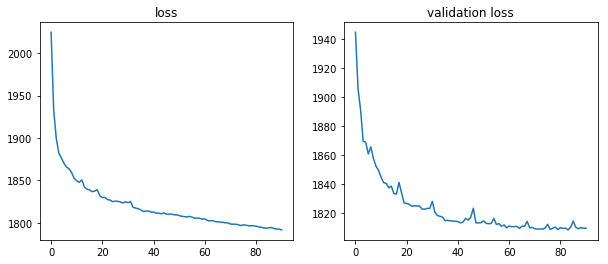

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Training history")
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(dense_cvae.history().history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(dense_cvae.history().history['val_loss'])
ax2.set_title('validation loss')

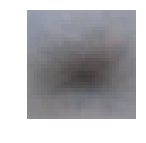

In [38]:
from keras.utils import np_utils

pic_size = 32

z_sample = np.random.rand(1, latent_size) # random 

plt.figure(figsize=(20, 2))
for i in range(1):
    c = np_utils.to_categorical(i, y_train1.shape[1])
    x_decoded = dense_cvae.generate_pic(z_sample, c)
    digit = x_decoded[0].reshape(pic_size, pic_size, 3)

    plt.subplot(1, y_train1.shape[1], i + 1)
    plt.axis('off')
    plt.imshow(digit)
plt.show()

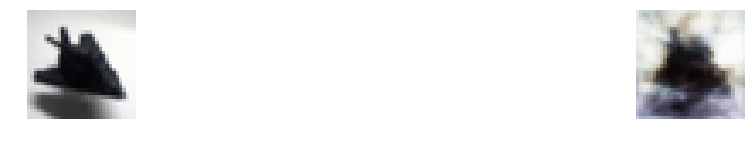

In [39]:
x_decoded = dense_cvae.enc_dec(x_train1[:1], y_train1[:1])

plt.figure(figsize=(20, 2))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(x_train1[0])

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(x_decoded[0])

plt.show()

# ConvCVAE

In [178]:
conv_cvae = ConvCVAE(nbatch, (latent_size,), x_train2.shape[1:], y_train2.shape[1:])
conv_cvae.train(x_train2[:2000], y_train2[:2000], x_test2, y_test2)

Train on 2000 samples, validate on 2000 samples
Epoch 1/80
2000/2000 [==============================] - 16s - loss: 2100.2732 - val_loss: 2125.7347
Epoch 2/80
2000/2000 [==============================] - 13s - loss: 1972.0125 - val_loss: 2132.5322
Epoch 3/80
2000/2000 [==============================] - 13s - loss: 1925.7647 - val_loss: 2133.6127
Epoch 4/80
2000/2000 [==============================] - 13s - loss: 1907.7008 - val_loss: 2124.9852
Epoch 5/80
2000/2000 [==============================] - 13s - loss: 1888.2952 - val_loss: 2115.2679
Epoch 6/80
2000/2000 [==============================] - 13s - loss: 1871.6179 - val_loss: 2105.7480
Epoch 7/80
2000/2000 [==============================] - 13s - loss: 1861.7012 - val_loss: 2088.1137
Epoch 8/80
2000/2000 [==============================] - 13s - loss: 1858.3071 - val_loss: 2079.8555
Epoch 9/80
2000/2000 [==============================] - 13s - loss: 1852.8635 - val_loss: 2071.5525
Epoch 10/80
2000/2000 [=============================

Training history


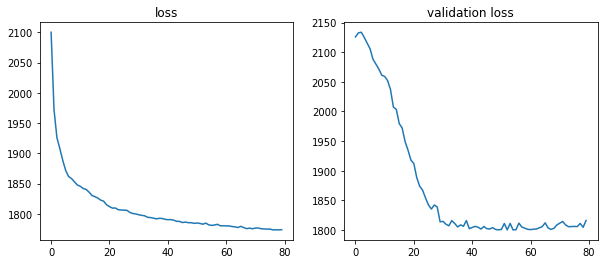

In [179]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Training history")
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(conv_cvae.history().history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(conv_cvae.history().history['val_loss'])
ax2.set_title('validation loss')

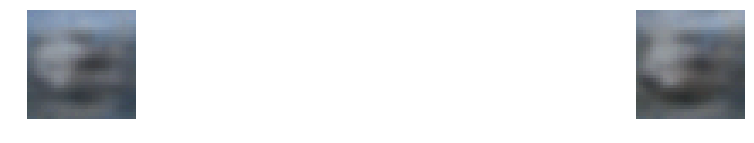

In [180]:
from keras.utils import np_utils
pic_size = 32

z_sample = np.random.rand(1, latent_size) # random 

plt.figure(figsize=(20, 2))
for i in range(2):
    c = np_utils.to_categorical(i, y_train2.shape[1])
    x_decoded = conv_cvae.generate_pic(z_sample, c)
    digit = x_decoded[0].reshape(pic_size, pic_size, 3)

    plt.subplot(1, y_train2.shape[1], i + 1)
    plt.axis('off')
    plt.imshow(digit)
plt.show()

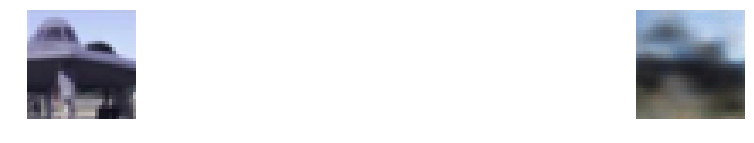

In [181]:
x_decoded = conv_cvae.enc_dec(x_train2[:1], y_train2[:1])

plt.figure(figsize=(20, 2))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(x_train2[0])

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(x_decoded[0])

plt.show()